# Pyrite Peak-to-Background Study

Study how the peak to background varies for Fe K & L and S K lines in pyrite fragments.  These spectra were specially collected to stress the peak-to-background metric.

<div style="text-align: right">Data collected by John Small</div>
<div style="text-align: right">Analysis by NWMR 22-Nov-2019</div>

In [1]:
using NeXLUncertainties
using NeXLCore
using NeXLSpectrum
using DataFrames
using Gadfly
using CSV

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\nritchie\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


Read in the spectrum data files.

In [2]:
ENV["columns"]=240
path = "Pyrite fragments"
# Read the standards
cus = [ readEMSA("$(path)/CuS_ChMxd_$(d)_15kV10nA130kHz_132kHz_100s.msa") for d in 1:3 ]
fe = [ readEMSA("$(path)/Fe_StdC_$(d)_15kV10nA130kHz_99kHz_100s.msa") for d in 1:3 ]
fes = [ readEMSA("$(path)/FeS_StdC_$(d)_15kV10nA130kHz_153kHz_100s.msa") for d in 1:3 ]
# Read the fragment spectra
dir = readdir(path)
points = [ [ readEMSA("$(path)/$(f)") for f in filter(ff->startswith(ff,"Pyrite_1_$(pt)"),dir) ] for pt in 'A':'M'];

# Show a sub-set of the spectrum metadata
asa(DataFrame,[cus..., fe..., fes..., points[1]...,points[2]...])

,Name,BeamEnergy,ProbeCurrent,LiveTime,RealTime,Coating,Integral,Material
,String,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Union…,Float64,String⍰
1,CuS,15000.0,10.0,100.0,132.446,,1.5463e7,CuS
2,CuS,15000.0,10.0,100.0,132.476,,1.54706e7,CuS
3,CuS,15000.0,10.0,100.0,132.46,,1.546e7,CuS
4,Fe,15000.0,10.0,100.0,122.798,,1.12526e7,Fe
5,Fe,15000.0,10.0,100.0,122.701,,1.12323e7,Fe
6,Fe,15000.0,10.0,100.0,122.816,,1.12384e7,Fe
7,FeS,15000.0,10.0,100.0,126.044,,1.27324e7,FeS
8,FeS,15000.0,10.0,100.0,125.961,,1.27044e7,FeS
9,FeS,15000.0,10.0,100.0,125.997,,1.27401e7,FeS


In [3]:
# Build the filtered references
det = matching(fes[1], 130.0, 120)
filt = buildfilter(VariableWidthFilter, det)
res = FilterFitResult[]
for d in 1:3 # for each detector
    s_std = fes[d]
    fe_std = fes[d]
    rr = [ 
        ( n"Fe", alltransitions, fe_std ),
        ( n"S", ktransitions, s_std ),
    ]
    rx = map(r ->(NeXLSpectrum.charFeature(r[1], r[2]), r[3]), rr)
    refs = collect(Iterators.flatten((r -> filter(r[2], det, r[1], filt, 1.0/dose(r[2]))).(rx)))
    append!(res, [ fit(pt[d],filt,refs,false) for pt in points ])
end

Tabulate the data, sort by characteristic line and write to a CSV file

In [4]:
df=vcat( (asa(DataFrame, r) for r in res)...)
sort!(df, :Feature)
CSV.write("$(path)/kratios.csv",df);

Tabulate the K-ratio data which includes the peak-to-background as the final column.

In [5]:
ENV["columns"]=240
df

,Label,Feature,Reference,Start,Stop,K,dK,Peak,Back,PtoB
,NeXLSpec…,NeXLSpec…,String,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,Pyrite_1_A1_15kV10nA130kHz_8kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,0.019105,0.000171289,41688.0,29571.5,55.7132
2,Pyrite_1_B1_15kV10nA130kHz_133kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,1.38947,0.00117047,1.45522e6,5.74008e5,100.192
3,Pyrite_1_C1_15kV10nA130kHz_86kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,0.36581,0.000607363,427385.0,1.95386e5,86.4463
4,Pyrite_1_D1_15kV10nA130kHz_116kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,1.08925,0.00102733,1.11114e6,4.20327e5,104.472
5,Pyrite_1_E1_15kV10nA130kHz_95kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,0.54078,0.000731617,618199.0,2.75233e5,88.7663
6,Pyrite_1_F1_15kV10nA130kHz_114kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,1.06784,0.00102492,1.10293e6,4.25702e5,102.391
7,Pyrite_1_G1_15kV10nA130kHz_129kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,1.33045,0.00112633,1.32105e6,4.7727e5,109.389
8,Pyrite_1_H1_15kV10nA130kHz_39kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,0.0921404,0.00030993,126874.0,68438.0,73.2648
9,Pyrite_1_I1_15kV10nA130kHz_129kHz_100s,Fe L3-M5 + 9 others,FeS,198,277,1.32245,0.00112472,1.31752e6,4.78821e5,108.744


Extract the peak-to-background data into a table associated with the individual spectra.

In [6]:
df2 = DataFrame(Label=df.Label[1:39], FeL=df.PtoB[1:39],SK=df.PtoB[40:78],FeKa=df.PtoB[79:117],FeKb=df.PtoB[118:156])
CSV.write("$(path)/PtoB.csv",df2)

"Pyrite fragments/PtoB.csv"

Provide a quick statistical summary of the above table.

In [7]:
describe(df2[!,2:5],:mean, :std, :min, :q25, :median, :q75, :max)

,variable,mean,std,min,q25,median,q75,max
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,FeL,91.4244,18.0972,55.7132,74.5635,96.5541,105.84,117.509
2,SK,901.108,207.282,269.383,874.854,906.055,981.483,1220.86
3,FeKa,555.43,94.8836,233.485,566.61,575.059,588.569,647.612
4,FeKb,137.479,20.5777,89.9746,131.378,133.286,138.324,186.347


Point A is very different from Point B.  Point A has significant quantities of carbon and a lot less Fe & S.

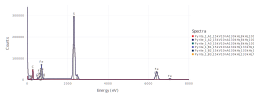

In [11]:
set_default_plot_size(10inch,4inch)
plot([ points[1]..., points[2]...],klms=[n"Fe",n"S", n"C", n"O"], yscale=1.0, xmax=8.0e3)

There seems to be a problem with unaccounted for O near the Fe L line.  This is particularly evident in the second of these plots in which the Fe L3-M5 roi clearly overlaps with the O K.  We need a O reference to correct this.

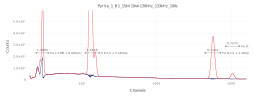

In [9]:
plot(res[2], 150:1600)

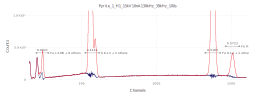

In [10]:
plot(res[8], 150:1600)